In [0]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Project
# Copyright: Zhaoshuo Li, Ding Hao, Mingyi Zheng
!pip install tensorboardX visdom image_slicer
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
#from torchvision import transforms
# import torchvision.transforms.functional as TF
from albumentations import *
import copy
import numpy as np
import random
from tensorboardX import SummaryWriter

#import transforms
from dataset import *
from visualization import *
from label_conversion import *
from dice_loss import *
from model_trainning import *
from model_from_ternaus import *
from deeplabv3p_resnet_super_label import SuperLabelDeepLabv3_plus
from deeplabv3p_resnet import DeepLabv3_plus
from unet import *

from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


In [0]:
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


## Hyperparameters

In [0]:
num_class = 12
num_superclasses = 2
super2sub = [[0,4,5,6,10],[1,2,3,7,8,9,11]]
num_filters = 64

In [0]:
weights = torch.ones((num_class,1)).to(device = device)

dice_loss1 = DICELoss(weights)
dice_loss2 = SuperLabelDICELoss(weights,_lambda=0.5) 

In [0]:
writer = SummaryWriter()

#DeepLabV3+: Superlabel vs Vanilla

### initialize models

In [0]:
#initialize model
model1 = DeepLabv3_plus(nInputChannels=3, n_classes=num_class, os=16, pretrained=True, _print=True)
model2 = SuperLabelDeepLabv3_plus(nInputChannels=3, n_super_classes = num_superclasses, n_classes=num_class, os=16, pretrained=True, _print=True,  super2sub = super2sub)
model1.to(device)
model2.to(device)

Constructing DeepLabv3+ model...
Number of classes: 12
Output stride: 16
Number of Input Channels: 3
Constructing DeepLabv3+ model...
Number of classes: 12
Output stride: 16
Number of Input Channels: 3


SuperLabelDeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequent

### load params

In [0]:
model1.load_state_dict(torch.load('/mydrive/My Drive/Colab Notebooks/deeplab_res_baseline.pt'))
model2.load_state_dict(torch.load('/mydrive/My Drive/Colab Notebooks/super_label_deeplabv3+.pt'))
print("Model loaded")

Model loaded


### dataloader

In [0]:
val_image_aug = Compose([
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])
validation_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/EndoVis2018Data/",data_type = "validation", transform_image=val_image_aug)
validation_generator = DataLoader(validation_dataset,shuffle=False,batch_size=1,num_workers=8)

### Prediction Comparison

In [0]:
worst, best = validate_and_compare(model1,model2,device,dice_loss1,dice_loss2,num_class,validation_generator,validation_dataset)

In [0]:
print("worst performance: dice {}".format(worst[1]))
print("best performance: dice {}".format(best[1]))


worst performance: dice [[-0.16855496]
 [-0.16557842]
 [-0.17841142]
 [-0.16215122]
 [-0.1649034 ]]
best performance: dice [[0.23929876]
 [0.1548351 ]
 [0.17933196]
 [0.10658944]
 [0.21909708]]


worst performance: dice [[-0.16855496]
 [-0.16557842]
 [-0.17841142]
 [-0.16215122]
 [-0.1649034 ]]
Input


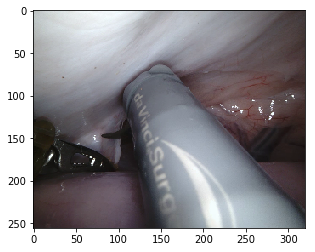

Label


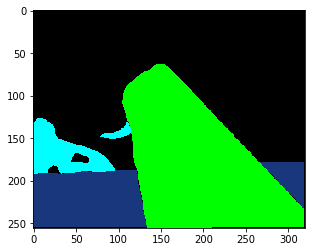

Baseline


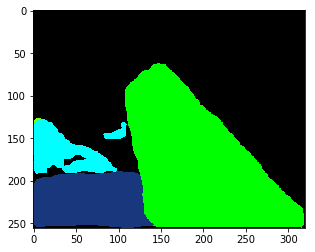

Super Label


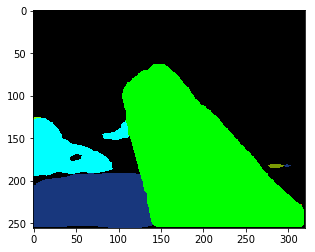

Input


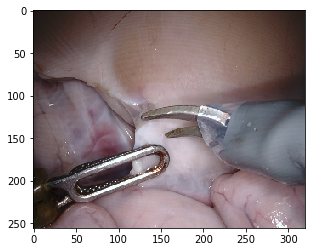

Label


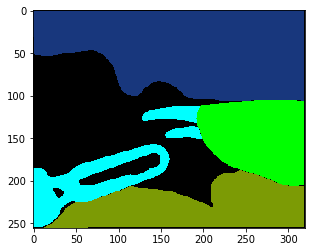

Baseline


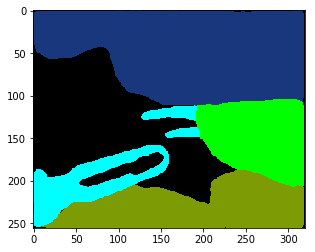

Super Label


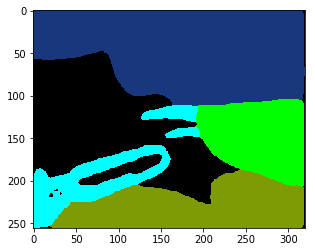

Input


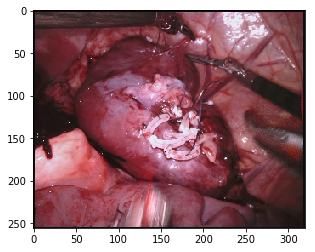

Label


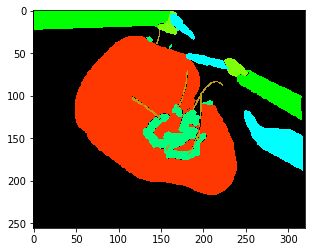

Baseline


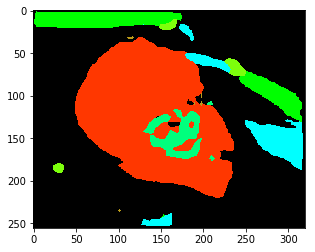

Super Label


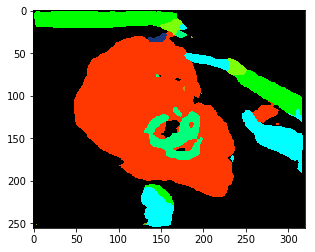

Input


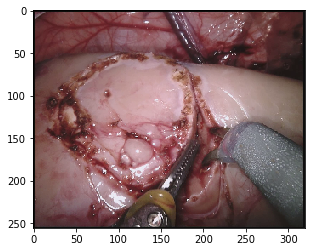

Label


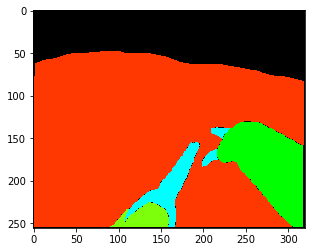

Baseline


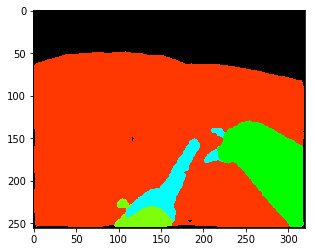

Super Label


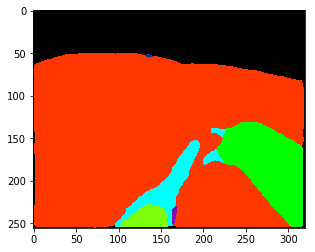

Input


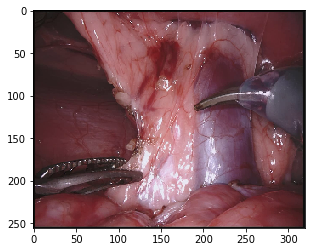

Label


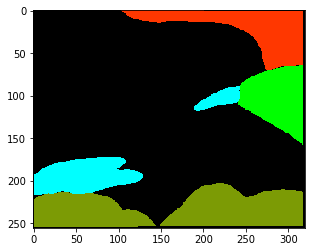

Baseline


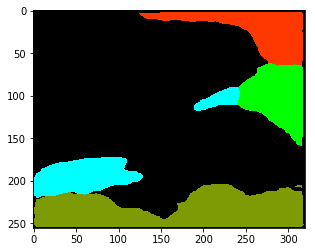

Super Label


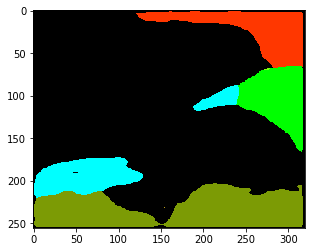

best performance: dice [[0.23929876]
 [0.1548351 ]
 [0.17933196]
 [0.10658944]
 [0.21909708]]
Baseline


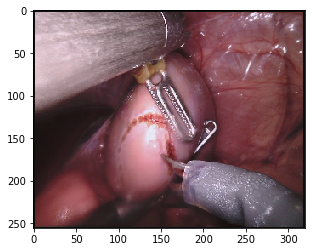

Label


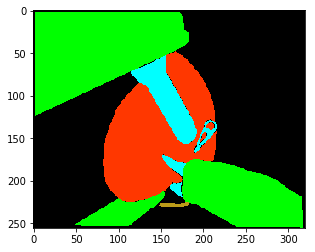

Baseline


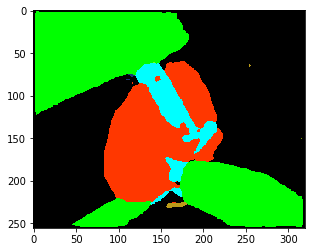

Super Label


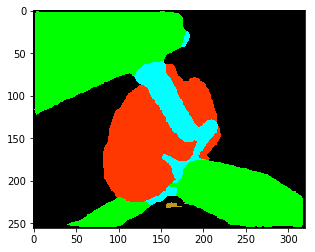

Baseline


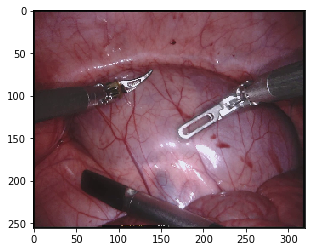

Label


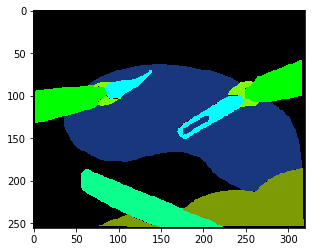

Baseline


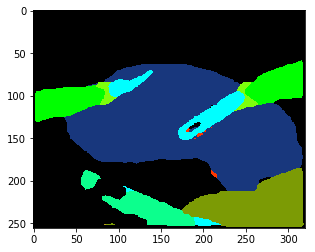

Super Label


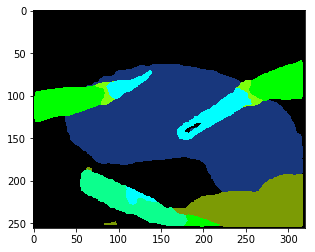

Baseline


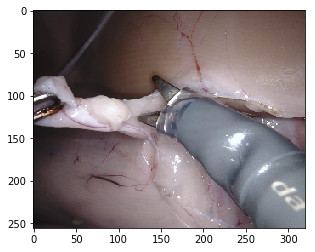

Label


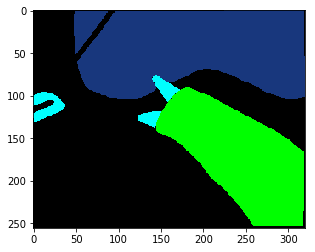

Baseline


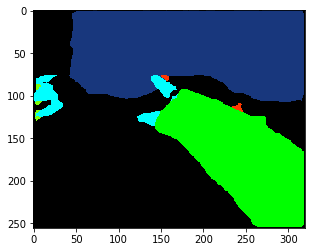

Super Label


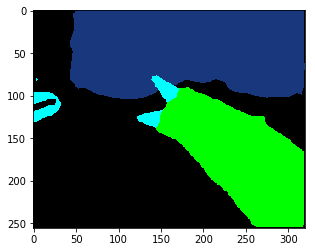

Baseline


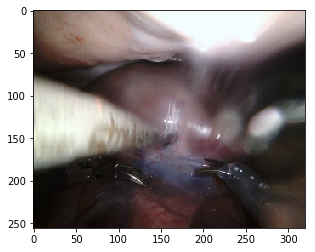

Label


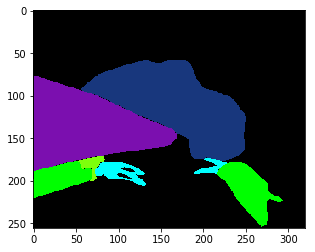

Baseline


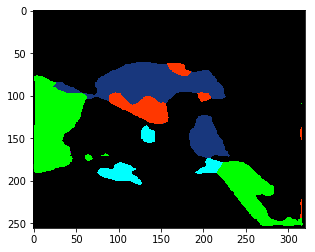

Super Label


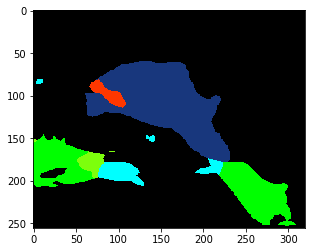

Baseline


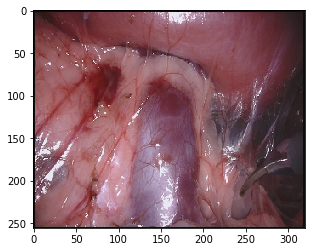

Label


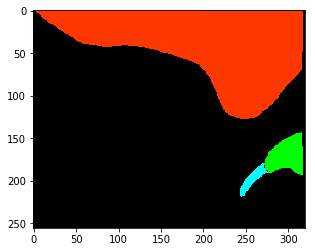

Baseline


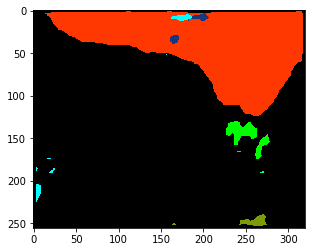

Super Label


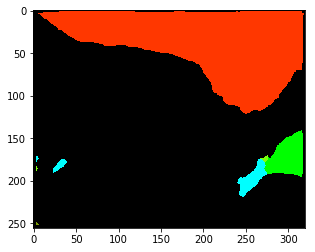

In [0]:
# show best and worst 
print("worst performance: dice {}".format(worst[1]))
batch = worst[0]
for i in range(0,5):
  img = batch[i]['img']
  label = batch[i]['label']
  
  output1 = model1(img.cuda())
  output2 = model2(img.cuda())
  
  pred1 = functional.softmax(output1.cpu(),dim=1)

  superclass_scores = output2[0]
  class_score = output2[1]
  final_class_score = torch.zeros_like(class_score)
  for i in range(num_superclasses):
    for j in super2sub[i]:
      final_class_score[:,j,:,:] = class_score[:,j,:,:]*superclass_scores[:,i,:,:]

  pred2 = functional.softmax(final_class_score.cpu(), dim=1)
  img.cpu()
  
  pred_label1 = torch.max(pred1,dim=1)[1]
  pred_label1 = pred_label1.cpu().type(label.type())
  
  pred_label2 = torch.max(pred2,dim=1)[1]
  pred_label2 = pred_label2.cpu().type(label.type())
  
  sample_img = img[0,:,:,:]
  sample_label = label[0,:,:,:]
  sample_colorlabel = validation_dataset.label_converter.label2color(sample_label.permute(1,2,0))
  sample_predcolorlabel1 = validation_dataset.label_converter.label2color(pred_label1.permute(1,2,0))
  sample_predcolorlabel2 = validation_dataset.label_converter.label2color(pred_label2.permute(1,2,0))

  print("Input")
  imshow(sample_img.permute(1,2,0),denormalize=True)
  print("Label")
  imshow(sample_colorlabel)
  print("Baseline")
  imshow(sample_predcolorlabel1)
  print("Super Label")
  imshow(sample_predcolorlabel2)

print("best performance: dice {}".format(best[1]))
batch = best[0]
for i in range(0,5):
  img = batch[i]['img']
  label = batch[i]['label']
  
  output1 = model1(img.cuda())
  output2 = model2(img.cuda())
  
  pred1 = functional.softmax(output1.cpu(),dim=1)

  superclass_scores = output2[0]
  class_score = output2[1]
  final_class_score = torch.zeros_like(class_score)
  for i in range(num_superclasses):
    for j in super2sub[i]:
      final_class_score[:,j,:,:] = class_score[:,j,:,:]*superclass_scores[:,i,:,:]

  pred2 = functional.softmax(final_class_score.cpu(), dim=1)
  img.cpu()
  
  pred_label1 = torch.max(pred1,dim=1)[1]
  pred_label1 = pred_label1.cpu().type(label.type())
  
  pred_label2 = torch.max(pred2,dim=1)[1]
  pred_label2 = pred_label2.cpu().type(label.type())
  
  sample_img = img[0,:,:,:]
  sample_label = label[0,:,:,:]
  sample_colorlabel = validation_dataset.label_converter.label2color(sample_label.permute(1,2,0))
  sample_predcolorlabel1 = validation_dataset.label_converter.label2color(pred_label1.permute(1,2,0))
  sample_predcolorlabel2 = validation_dataset.label_converter.label2color(pred_label2.permute(1,2,0))

  print("Baseline")
  imshow(sample_img.permute(1,2,0),denormalize=True)
  print("Label")
  imshow(sample_colorlabel)
  print("Baseline")
  imshow(sample_predcolorlabel1)
  print("Super Label")
  imshow(sample_predcolorlabel2)

# See the best and worst 5 of superlabel

In [0]:
_, _, _, _, _, worst, best = validate(model2,device,dice_loss2,num_class,validation_generator,validation_dataset,writer,0)

Vaildation Loss: 0.5692
0 Class, True Pos 12658483.0, False Pos 456736.0, False Neg 447210.0, Num Pixel 13105693.0, Dice score 0.97
1 Class, True Pos 2437191.0, False Pos 120910.0, False Neg 102008.0, Num Pixel 2539199.0, Dice score 0.96
2 Class, True Pos 1204996.0, False Pos 152452.0, False Neg 130434.0, Num Pixel 1335430.0, Dice score 0.89
3 Class, True Pos 489731.0, False Pos 67746.0, False Neg 74039.0, Num Pixel 563770.0, Dice score 0.87
4 Class, True Pos 4767198.0, False Pos 186397.0, False Neg 170321.0, Num Pixel 4937519.0, Dice score 0.96
5 Class, True Pos 3345384.0, False Pos 139932.0, False Neg 148415.0, Num Pixel 3493799.0, Dice score 0.96
6 Class, True Pos 61781.0, False Pos 20992.0, False Neg 32405.0, Num Pixel 94186.0, Dice score 0.70
7 Class, True Pos 124781.0, False Pos 13533.0, False Neg 14741.0, Num Pixel 139522.0, Dice score 0.90
8 Class, True Pos 138.0, False Pos 91.0, False Neg 361.0, Num Pixel 499.0, Dice score 0.38
9 Class, True Pos 83627.0, False Pos 5887.0, Fals

worst performance: dice [[0.60826951]
 [0.51516443]
 [0.5479461 ]
 [0.64235574]
 [0.67327839]]
Input


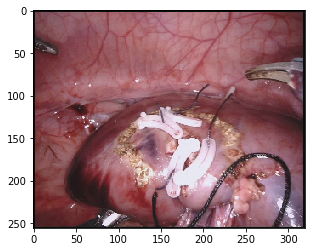

Label


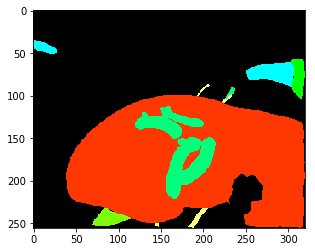

Pred


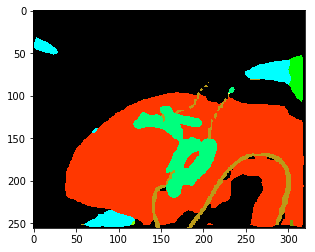

Input


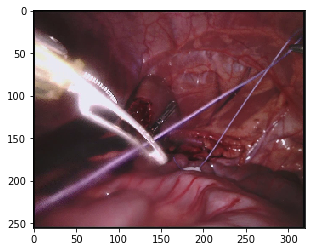

Label


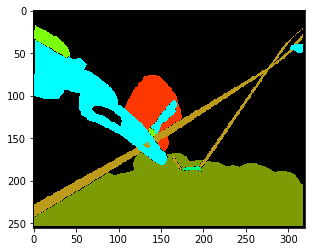

Pred


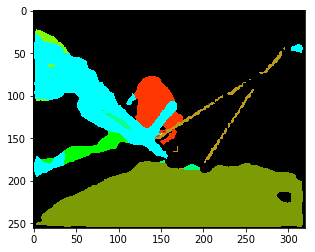

Input


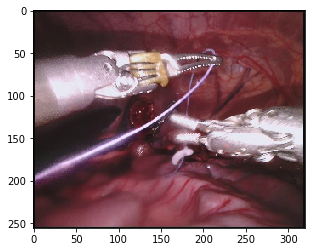

Label


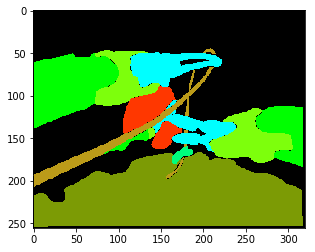

Pred


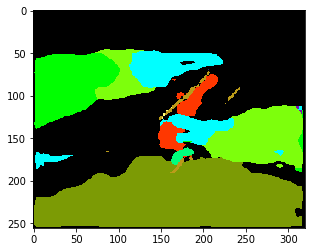

Input


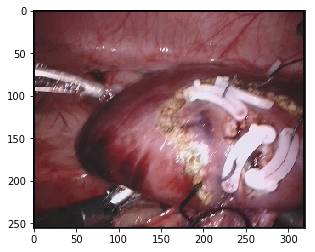

Label


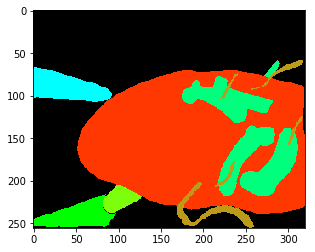

Pred


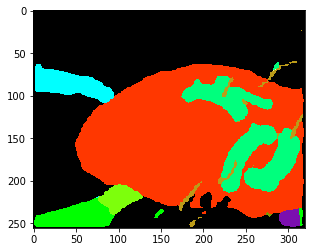

Input


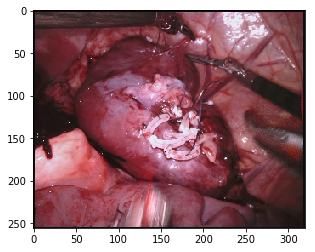

Label


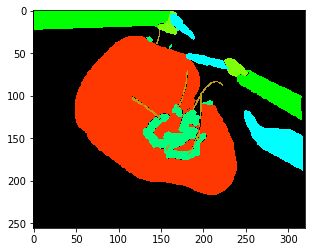

Pred


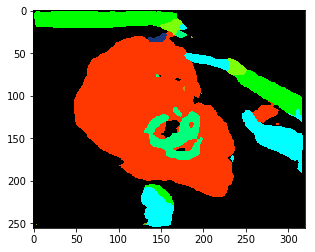

best performance: dice [[0.99489373]
 [0.9947381 ]
 [0.99871653]
 [0.99247551]
 [0.99876148]]
Input


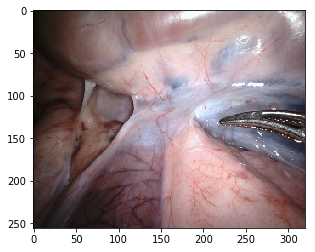

Label


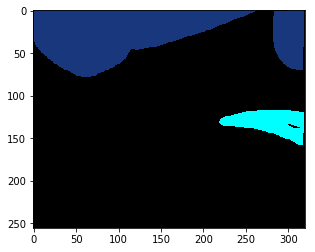

Pred


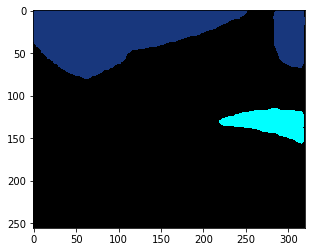

Input


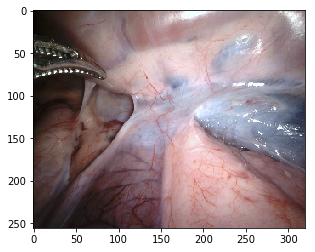

Label


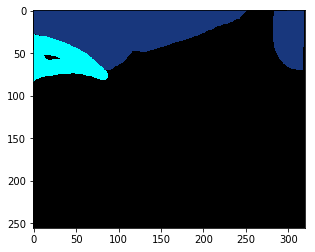

Pred


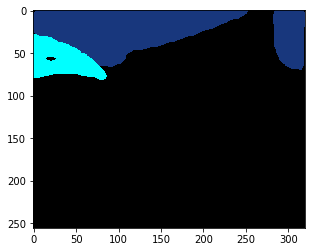

Input


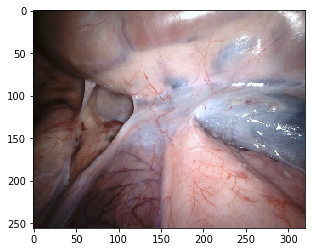

Label


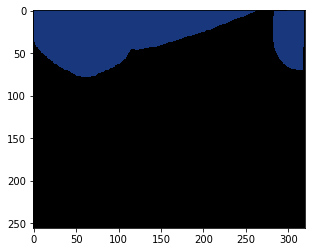

Pred


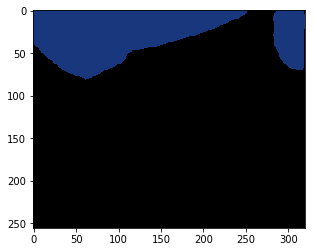

Input


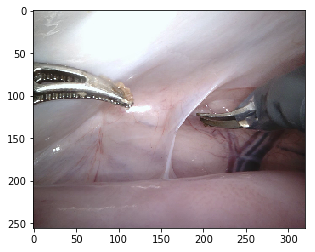

Label


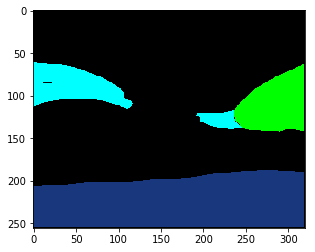

Pred


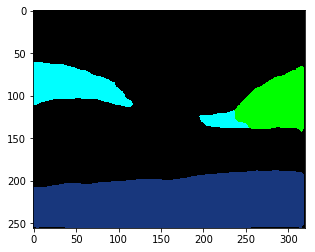

Input


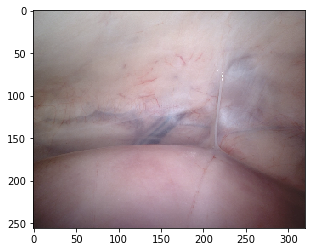

Label


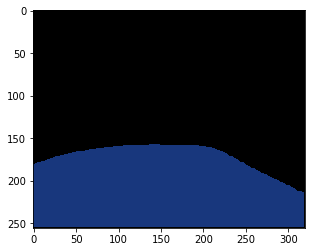

Pred


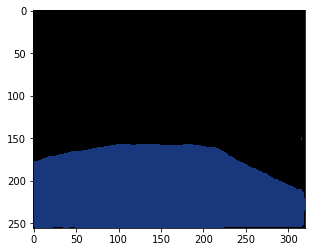

In [0]:
# show best and worst 
print("worst performance: dice {}".format(worst[1]))
batch = worst[0]
for i in range(0,5):
  img = batch[i]['img']
  label = batch[i]['label']
  
  output2 = model2(img.cuda())
  
  superclass_scores = output2[0]
  class_score = output2[1]
  final_class_score = torch.zeros_like(class_score)
  for i in range(num_superclasses):
    for j in super2sub[i]:
      final_class_score[:,j,:,:] = class_score[:,j,:,:]*superclass_scores[:,i,:,:]

  pred2 = functional.softmax(final_class_score.cpu(), dim=1)
  img.cpu()
    
  pred_label2 = torch.max(pred2,dim=1)[1]
  pred_label2 = pred_label2.cpu().type(label.type())
  
  sample_img = img[0,:,:,:]
  sample_label = label[0,:,:,:]
  sample_colorlabel = validation_dataset.label_converter.label2color(sample_label.permute(1,2,0))
  sample_predcolorlabel2 = validation_dataset.label_converter.label2color(pred_label2.permute(1,2,0))

  print("Input")
  imshow(sample_img.permute(1,2,0),denormalize=True)
  print("Label")
  imshow(sample_colorlabel)
  print("Pred")
  imshow(sample_predcolorlabel2)

print("best performance: dice {}".format(best[1]))
batch = best[0]
for i in range(0,5):
  img = batch[i]['img']
  label = batch[i]['label']
  
  output2 = model2(img.cuda())
  
  superclass_scores = output2[0]
  class_score = output2[1]
  final_class_score = torch.zeros_like(class_score)
  for i in range(num_superclasses):
    for j in super2sub[i]:
      final_class_score[:,j,:,:] = class_score[:,j,:,:]*superclass_scores[:,i,:,:]

  pred2 = functional.softmax(final_class_score.cpu(), dim=1)
  img.cpu()
    
  pred_label2 = torch.max(pred2,dim=1)[1]
  pred_label2 = pred_label2.cpu().type(label.type())
  
  sample_img = img[0,:,:,:]
  sample_label = label[0,:,:,:]
  sample_colorlabel = validation_dataset.label_converter.label2color(sample_label.permute(1,2,0))
  sample_predcolorlabel2 = validation_dataset.label_converter.label2color(pred_label2.permute(1,2,0))

  print("Input")
  imshow(sample_img.permute(1,2,0),denormalize=True)
  print("Label")
  imshow(sample_colorlabel)
  print("Pred")
  imshow(sample_predcolorlabel2)